In [1]:
import sys 
import numpy as np
import struct
import os  
import torch 
import torch.nn as nn 
import matplotlib.pylab as plt 

/home/sza/miniconda3/envs/mae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_name = 'data/sdf1_points.bin'
file = open(file_name,'rb')
size = os.path.getsize(file_name)
N = struct.unpack('i', file.read(4))[0]
print(N)
points = []
for _ in range(N):
    x, y, z = struct.unpack('fff', file.read(12))
    points.append([x, y, z])

# Read the reference distances
distances = list(struct.unpack(f'{N}f', file.read(4 * N)))
file.close()

5000


In [3]:
def find_coefficients(points, distances):
    N = len(points)
    X = np.column_stack((points, np.ones(N)))
    Y = np.array(distances).reshape(N, 1)
    beta = np.linalg.lstsq(X, Y, rcond=None)[0]
    k1, k2, k3, b = beta.ravel()
    return k1, k2, k3, b

In [4]:
k1, k2, k3, b = find_coefficients(points, distances)
print(f"y = {k1} * x1 + {k2} * x2 + {k3} * x3 + {b}")

y = 0.06525616369861703 * x1 + -0.08443566584023188 * x2 + -0.20407869619776775 * x3 + 0.5063420488947121


In [5]:
points = np.array(points)
distances = np.array(distances)
print(points.shape)
print(distances.shape)

(5000, 3)
(5000,)


In [6]:
y_ = k1 * points[:,0] + k2 * points[:,1] + k3 * points[:,2] + b 
err = abs(y-y_).mean()
print(err)

0.11189515189455315


In [9]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        # pass 
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output       

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [8]:
device = 'cuda'

In [10]:
model = Siren(in_features=3, out_features=1, hidden_features=64, 
                  hidden_layers=2, outermost_linear=True)
optimizer = torch.optim.Adam(model.parameters(),0.00005)
model.to(device)
model.train()
# loss_fn = torch.nn.MSELoss()
x = torch.tensor(points).float()
y = torch.tensor(distances).float()
x = x.to(device)
y = y.to(device).unsqueeze(1)
loss_total = [] 
for i in range(15000):
    y_pred = model(x)
    loss = ((y_pred-y)**2).mean()
    loss_total.append(loss.item())
    print(f'loss: {loss.item():1f}, epoch: {i}')
    
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()

loss: 0.380651, epoch: 0
loss: 0.372643, epoch: 1
loss: 0.364734, epoch: 2
loss: 0.356932, epoch: 3
loss: 0.349240, epoch: 4
loss: 0.341666, epoch: 5
loss: 0.334212, epoch: 6
loss: 0.326883, epoch: 7
loss: 0.319679, epoch: 8
loss: 0.312603, epoch: 9
loss: 0.305654, epoch: 10
loss: 0.298836, epoch: 11
loss: 0.292148, epoch: 12
loss: 0.285592, epoch: 13
loss: 0.279169, epoch: 14
loss: 0.272881, epoch: 15
loss: 0.266730, epoch: 16
loss: 0.260717, epoch: 17
loss: 0.254845, epoch: 18
loss: 0.249115, epoch: 19
loss: 0.243531, epoch: 20
loss: 0.238095, epoch: 21
loss: 0.232808, epoch: 22
loss: 0.227674, epoch: 23
loss: 0.222695, epoch: 24
loss: 0.217870, epoch: 25
loss: 0.213202, epoch: 26
loss: 0.208691, epoch: 27
loss: 0.204336, epoch: 28
loss: 0.200135, epoch: 29
loss: 0.196088, epoch: 30
loss: 0.192191, epoch: 31
loss: 0.188441, epoch: 32
loss: 0.184833, epoch: 33
loss: 0.181364, epoch: 34
loss: 0.178028, epoch: 35
loss: 0.174820, epoch: 36
loss: 0.171735, epoch: 37
loss: 0.168767, epoch:

KeyboardInterrupt: 

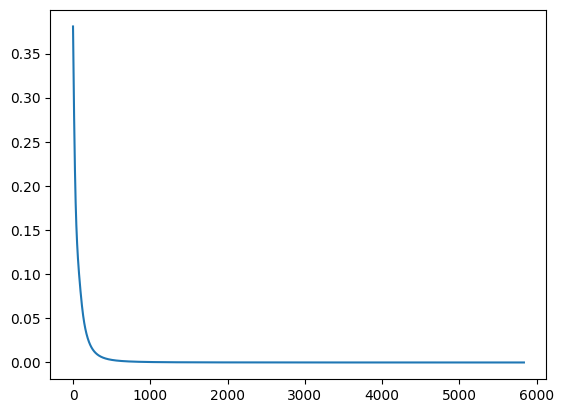

In [11]:
plt.plot(loss_total)

In [26]:
x = x.to(device)
y = y.to(device)
for i in range(15000):
    y_pred = model(x)
    loss = ((y_pred-y)**2).mean()
    print(loss.item())
    
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()

0.45070168375968933
0.4413406252861023
0.4320716857910156
0.4229015111923218
0.41383638978004456
0.40488263964653015
0.396045982837677
0.38733112812042236
0.37874120473861694
0.37027856707572937
0.361945241689682
0.35374340415000916
0.34567520022392273
0.3377425968647003
0.32994744181632996
0.32229137420654297
0.31477615237236023
0.307403564453125
0.30017566680908203
0.2930947542190552
0.28616341948509216
0.2793843150138855
0.27276039123535156
0.2662944197654724
0.25998926162719727
0.2538474500179291
0.24787132441997528
0.24206283688545227
0.23642349243164062
0.2309543639421463
0.22565597295761108
0.22052831947803497
0.2155708521604538
0.21078255772590637
0.20616184175014496
0.2017066776752472
0.19741462171077728
0.1932828426361084
0.18930809199810028
0.18548683822155
0.18181519210338593
0.1782890409231186
0.17490407824516296
0.17165571451187134
0.16853941977024078
0.16555047035217285
0.1626841127872467
0.15993571281433105
0.15730056166648865
0.15477409958839417
0.15235185623168945
0.1

KeyboardInterrupt: 